# U.S. corporate bond price prediction.

#### Opening the dataset.

Opening the dataset to have a quick look at it. The dataset that is going to be loaded is a clean version of the original dataset. I removed all datapoints that contained at least one NaN column so analysis is easier. I removed 17669 datapoints (2% of the dataset) that had NaN features. I did this instead of using the approach of the benchmark model that replaces NaN values with -1000, since doing this will add unnecessary skew to the data. Also the 'id' and 'bond_id' columns were removed since we're not re-constructing the time-series where this data set was obtained from.

In [1]:
import pandas as pd
import numpy as np
import visuals as vs
import matplotlib.pyplot as plt


# Pretty display for notebooks
%matplotlib inline


pd.set_option('display.max_columns', None)
train_data = pd.read_csv('train_clean.csv')
train_data = train_data.drop(['Unnamed: 0'], axis=1)

# Showing only the first 6 datapoints.
train_data.head(6)

,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,126.26800,7.616851,5.95,25.940349,0,12.540,150000,3,126.017363,343747,125.10100,400000,3,124.717608,345050.0,124.75700,1000000.0,3.0,124.721953,684386.0,126.06100,220000.0,3.0,126.180334,1295498.0,128.891,29000.0,4.0,126.636079,1308464.0,124.918,10000.0,2.0,125.736081,2152948.0,126.362,5000001.0,2.0,127.025765,2157390.0,126.880,4200000.0,3.0,126.761433,2407701.0,126.673,85000.0,4.0,126.323528,2862729.0,128.596,120000.0,2.0,127.561201,3621492.0,129.089,200000.0,2.0,129.435587
1,128.39900,6.434827,5.95,25.932570,0,1.990,1350000,3,128.262332,245336,126.26800,150000,3,126.017363,589083.0,125.10100,400000.0,3.0,124.717608,590387.0,124.75700,1000000.0,3.0,124.721953,929723.0,126.061,220000.0,3.0,126.180334,1540835.0,128.891,29000.0,4.0,126.636079,1553800.0,124.918,10000.0,2.0,125.736081,2398284.0,126.362,5000001.0,2.0,127.025765,2402726.0,126.880,4200000.0,3.0,126.761433,2653037.0,126.673,85000.0,4.0,126.323528,3108066.0,128.596,120000.0,2.0,127.561201
2,130.51939,8.635508,5.95,25.918559,0,21.170,10000,3,127.833688,441839,128.39900,1350000,3,128.262332,687175.0,126.26800,150000.0,3.0,126.017363,1030923.0,125.10100,400000.0,3.0,124.717608,1032226.0,124.757,1000000.0,3.0,124.721953,1371562.0,126.061,220000.0,3.0,126.180334,1982674.0,128.891,29000.0,4.0,126.636079,1995639.0,124.918,10000.0,2.0,125.736081,2840124.0,126.362,5000001.0,2.0,127.025765,2844565.0,126.880,4200000.0,3.0,126.761433,3094876.0,126.673,85000.0,4.0,126.323528
3,131.47109,5.556972,5.95,25.912757,0,45.073,5000,3,125.490402,182963,130.51939,10000,3,127.833688,624803.0,128.39900,1350000.0,3.0,128.262332,870139.0,126.26800,150000.0,3.0,126.017363,1213886.0,125.101,400000.0,3.0,124.717608,1215190.0,124.757,1000000.0,3.0,124.721953,1554526.0,126.061,220000.0,3.0,126.180334,2165638.0,128.891,29000.0,4.0,126.636079,2178603.0,124.918,10000.0,2.0,125.736081,3023088.0,126.362,5000001.0,2.0,127.025765,3027529.0,126.880,4200000.0,3.0,126.761433
4,131.14667,8.430186,5.95,25.899405,0,43.440,8000,3,127.637634,421078,131.47109,5000,3,125.490402,604042.0,130.51939,10000.0,3.0,127.833688,1045881.0,128.39900,1350000.0,3.0,128.262332,1291217.0,126.268,150000.0,3.0,126.017363,1634965.0,125.101,400000.0,3.0,124.717608,1636268.0,124.757,1000000.0,3.0,124.721953,1975604.0,126.061,220000.0,3.0,126.180334,2586716.0,128.891,29000.0,4.0,126.636079,2599682.0,124.918,10000.0,2.0,125.736081,3444166.0,126.362,5000001.0,2.0,127.025765
5,125.80000,9.308894,5.95,25.883124,0,3.810,900000,2,127.617151,513434,131.14667,8000,3,127.637634,934512.0,131.47109,5000.0,3.0,125.490402,1117476.0,130.51939,10000.0,3.0,127.833688,1559315.0,128.399,1350000.0,3.0,128.262332,1804652.0,126.268,150000.0,3.0,126.017363,2148399.0,125.101,400000.0,3.0,124.717608,2149703.0,124.757,1000000.0,3.0,124.721953,2489039.0,126.061,220000.0,3.0,126.180334,3100150.0,128.891,29000.0,4.0,126.636079,3113116.0,124.918,10000

### Exploration: getting basic statistics.

In [2]:
train_data.describe()

,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
count,745009.000000,745009.000000,745009.000000,745009.000000,745009.00000,7.450090e+05,7.450090e+05,745009.000000,745009.000000,7.450090e+05,745009.000000,7.450090e+05,745009.000000,745009.000000,7.450090e+05,745009.000000,7.450090e+05,745009.000000,745009.000000,7.450090e+05,745009.000000,7.450090e+05,745009.000000,745009.000000,7.450090e+05,745009.00000,7.450090e+05,745009.000000,745009.000000,7.450090e+05,745009.000000,7.450090e+05,745009.000000,745009.000000,7.450090e+05,745009.000000,7.450090e+05,745009.000000,745009.000000,7.450090e+05,745009.000000,7.450090e+05,745009.000000,745009.000000,7.450090e+05,745009.000000,7.450090e+05,745009.000000,745009.000000,7.450090e+05,745009.000000,7.450090e+05,745009.000000,745009.000000,7.450090e+05,745009.000000,7.450090e+05,745009.000000,745009.000000
mean,103.385926,0.931231,5.583540,6.535069,0.10996,2.842487e+04,2.639964e+05,3.234494,103.156155,2.871888e+04,103.382188,2.638220e+05,3.234682,103.152793,5.756193e+04,103.378203,2.638508e+05,3.234976,103.149409,8.625727e+04,103.374198,2.638438e+05,3.234911,103.146156,1.149324e+05,103.37044,2.639313e+05,3.234870,103.142994,1.434387e+05,103.366847,2.640834e+05,3.234947,103.140084,1.718906e+05,103.363449,2.641347e+05,3.234939,103.137525,2.004106e+05,103.360449,2.641739e+05,3.234929,103.135222,2.288337e+05,103.357693,2.642973e+05,3.234972,103.133224,2.573266e+05,103.355140,2.643355e+05,3.234925,103.131439,2.855445e+05,103.352461,2.645629e+05,3.234372,103.129880
std,9.755676,1.995004,1.718235,6.238201,0.31284,1.073286e+06,7.679295e+05,0.763573,9.862076,1.411307e+05,9.756812,7.675338e+05,0.763633,9.863332,2.070856e+05,9.757710,7.675759e+05,0.763628,9.864102,2.665315e+05,9.758350,7.673815e+05,0.763679,9.864729,3.220331e+05,9.75872,7.674434e+05,0.763768,9.865189,3.746559e+05,9.758779,7.677846e+05,0.763820,9.865395,4.261561e+05,9.758358,7.677770e+05,0.763877,9.865229,4.776297e+05,9.757815,7.677863e+05,0.763901,9.864972,5.277847e+05,9.757357,7.678853e+05,0.763929,9.864447,5.778244e+05,9.756761,7.677525e+05,0.763954,9.863981,6.261445e+05,9.756000,7.681829e+05,0.764265,9.863560
min,1.009000,0.012991,0.000000,0.082471,0.00000,-5.858100e+01,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.00900,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127
25%,99.399700,0.036745,4.750000,2.488486,0.00000,2.492000e+00,1.000000e+04,3.000000,98.865899,7.000000e+00,99.395000,1.000000e+04,3.000000,98.862313

In [3]:
# Calculating range for each data feature.
features_range = train_data.apply(lambda x: x.max() - x.min())

features_range.sort_values(ascending=False)

reporting_delay              9.987920e+07
received_time_diff_last10    1.148696e+07
received_time_diff_last9     1.133542e+07
received_time_diff_last8     1.133532e+07
received_time_diff_last7     1.130840e+07
received_time_diff_last6     1.011778e+07
received_time_diff_last5     9.504827e+06
received_time_diff_last4     9.072611e+06
received_time_diff_last3     8.999924e+06
received_time_diff_last2     8.999916e+06
received_time_diff_last1     8.649142e+06
trade_size_last3             5.000000e+06
trade_size_last5             5.000000e+06
trade_size_last4             5.000000e+06
trade_size_last7             5.000000e+06
trade_size_last2             5.000000e+06
trade_size_last8             5.000000e+06
trade_size_last1             5.000000e+06
trade_size_last9             5.000000e+06
trade_size                   5.000000e+06
trade_size_last10            5.000000e+06
trade_size_last6             5.000000e+06
curve_based_price_last5      1.779113e+02
curve_based_price_last10     1.779

After calculating the statistics of the dataset, there are some things that can be said about it:

- The range between each feature values is big, this means that data normalization has to be performed before we can train any ML model. Another proof of this is that range between features differs a lot, it can be noticed between the group of features reported_delay, received_time_diff{1-10}, trade_size_last{1-10} and the rest of the features which have a lower range.


- The features with higher range such as: reported_delay, received_time_diff{1-10}, trade_size_last{1-10} may have some outliers so these may be treated as highly skewed features and log transformation may be required. In any case the skew for each feature will be calculated in order to know the highly-skewed ones.

### Data exploration: bond price distribution.

Text(0.5,0.98,'Data behavior visualization')

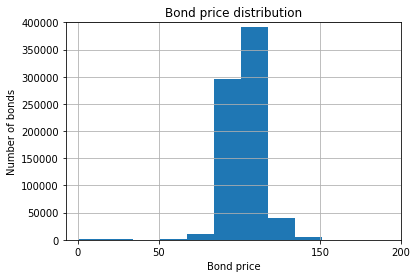

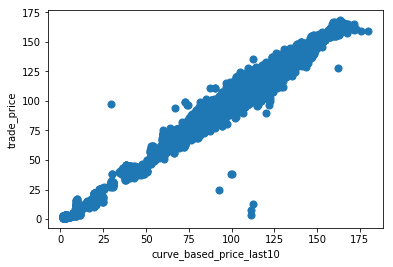

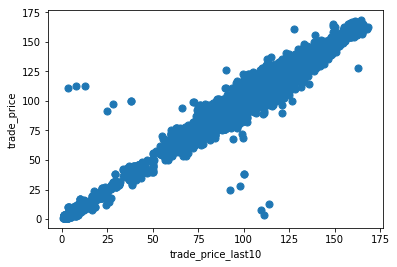

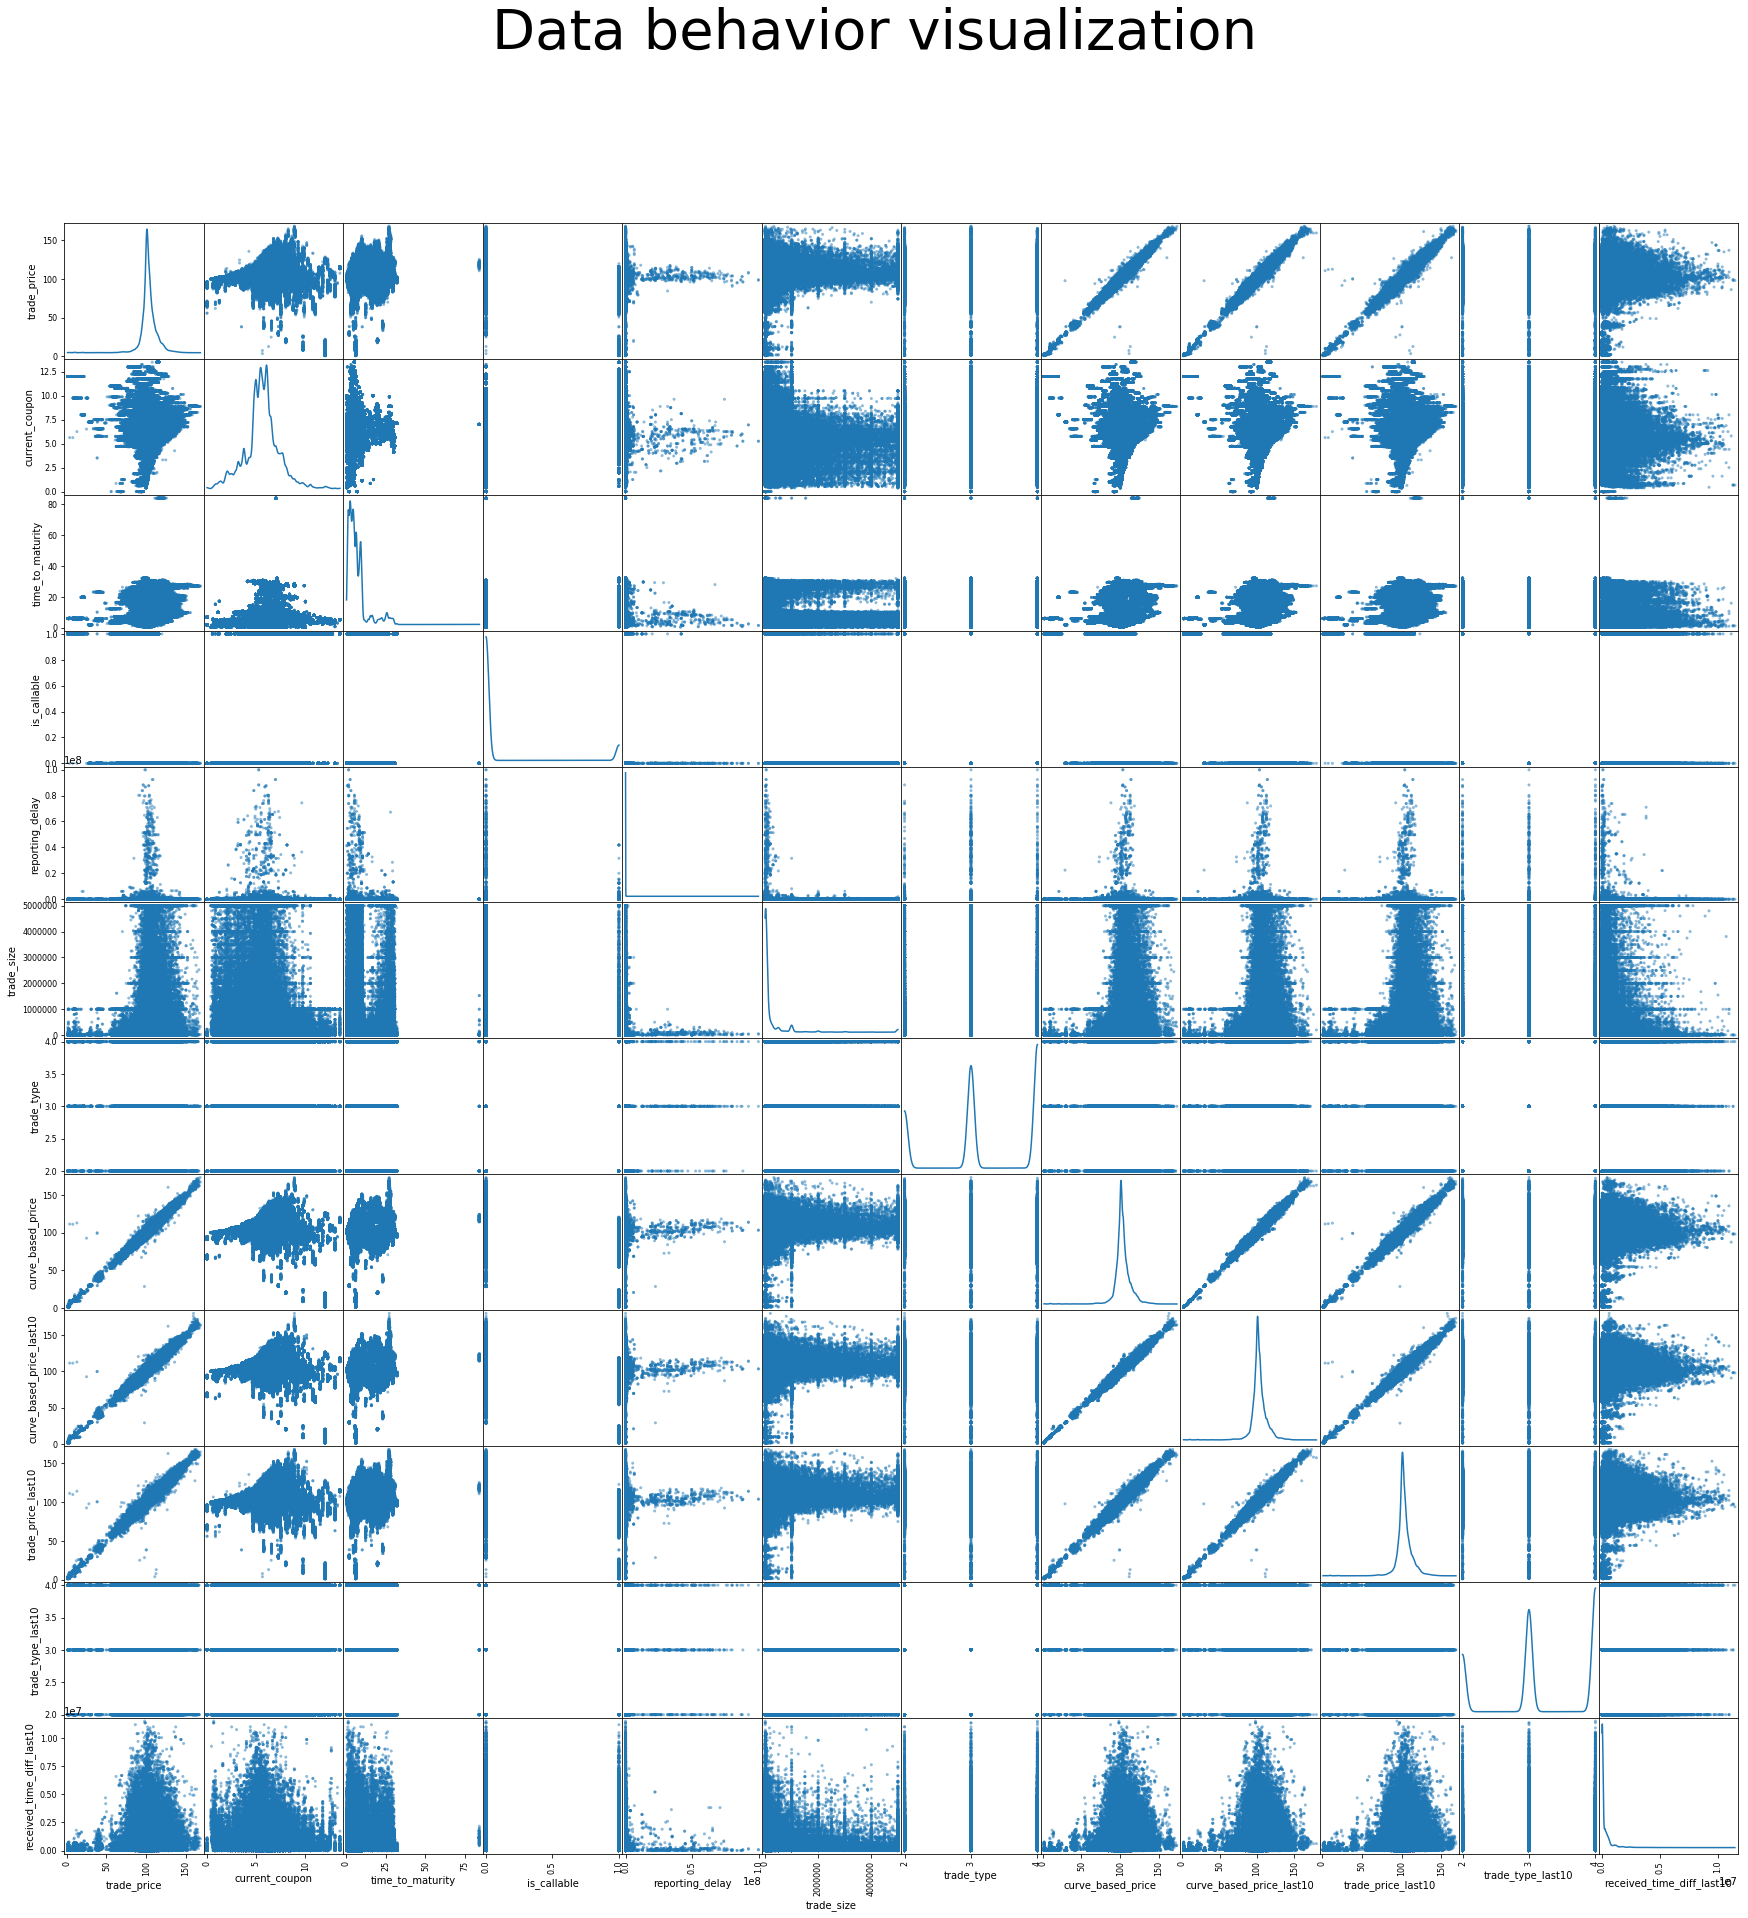

In [4]:
from pandas.plotting import scatter_matrix

ax = pd.Series.hist(train_data['trade_price'])
ax.set_xlabel('Bond price')
ax.set_ylabel('Number of bonds')
ax.set_title('Bond price distribution')
ax.set_ylim(0,400000)
ax.set_xticks([0, 50, 150, 200])

train_data.plot.scatter(x='curve_based_price_last10', y='trade_price', s=50)
train_data.plot.scatter(x='trade_price_last10', y='trade_price', s=50)

features_to_plot = ['trade_price', 'current_coupon', 'time_to_maturity', 'is_callable', 'reporting_delay', 'trade_size', 'trade_type', 'curve_based_price', 'curve_based_price_last10', 'trade_price_last10','trade_type_last10', 'received_time_diff_last10']
scatter_matrix(train_data[features_to_plot], figsize=(30,30), diagonal='kde')
plt.suptitle('Data behavior visualization', fontsize=56)

- After plotting the bond price distribution, it follows a normal distribution with a little skew to the left. It has a mean between the prices US\$100 and US\$125.

- There are less than 50,000 bonds with prices under US\$50. The distribution has a low standard deviation because when looking at its Gauss bell shape has a low width, and this width is equivalent to the standard deviation. This means that the bonds trade prices are very close each other which is also confirmed with the value of US\$9.755676 for standard deviation on the first table.

- After plotting the scatter matrix with the data behavior based on the trade_price_last10 and curve_based_price_last10, the plot shows that the data has a linear behavior so a linear model can be suitable to fit this data. The prices were selected instead of the other features since the focus of the problem is to predict prices based on the previous prices it had on the last transactions. Also for the big amount of data we probably need an iterative model.

### Pre-processing:  Splitting features from target variable.

In [5]:
bond_prices = train_data['trade_price']
train_data = train_data.drop('trade_price', axis=1)

train_data

,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,7.616851,5.95,25.940349,0,12.540,150000,3,126.017363,343747,125.10100,400000,3,124.717608,345050.0,124.75700,1000000.0,3.0,124.721953,684386.0,126.06100,220000.0,3.0,126.180334,1295498.0,128.89100,29000.0,4.0,126.636079,1308464.0,124.91800,10000.0,2.0,125.736081,2152948.0,126.36200,5000001.0,2.0,127.025765,2157390.0,126.88000,4200000.0,3.0,126.761433,2407701.0,126.67300,85000.0,4.0,126.323528,2862729.0,128.59600,120000.0,2.0,127.561201,3621492.0,129.08900,200000.0,2.0,129.435587
1,6.434827,5.95,25.932570,0,1.990,1350000,3,128.262332,245336,126.26800,150000,3,126.017363,589083.0,125.10100,400000.0,3.0,124.717608,590387.0,124.75700,1000000.0,3.0,124.721953,929723.0,126.06100,220000.0,3.0,126.180334,1540835.0,128.89100,29000.0,4.0,126.636079,1553800.0,124.91800,10000.0,2.0,125.736081,2398284.0,126.36200,5000001.0,2.0,127.025765,2402726.0,126.88000,4200000.0,3.0,126.761433,2653037.0,126.67300,85000.0,4.0,126.323528,3108066.0,128.59600,120000.0,2.0,127.561201
2,8.635508,5.95,25.918559,0,21.170,10000,3,127.833688,441839,128.39900,1350000,3,128.262332,687175.0,126.26800,150000.0,3.0,126.017363,1030923.0,125.10100,400000.0,3.0,124.717608,1032226.0,124.75700,1000000.0,3.0,124.721953,1371562.0,126.06100,220000.0,3.0,126.180334,1982674.0,128.89100,29000.0,4.0,126.636079,1995639.0,124.91800,10000.0,2.0,125.736081,2840124.0,126.36200,5000001.0,2.0,127.025765,2844565.0,126.88000,4200000.0,3.0,126.761433,3094876.0,126.67300,85000.0,4.0,126.323528
3,5.556972,5.95,25.912757,0,45.073,5000,3,125.490402,182963,130.51939,10000,3,127.833688,624803.0,128.39900,1350000.0,3.0,128.262332,870139.0,126.26800,150000.0,3.0,126.017363,1213886.0,125.10100,400000.0,3.0,124.717608,1215190.0,124.75700,1000000.0,3.0,124.721953,1554526.0,126.06100,220000.0,3.0,126.180334,2165638.0,128.89100,29000.0,4.0,126.636079,2178603.0,124.91800,10000.0,2.0,125.736081,3023088.0,126.36200,5000001.0,2.0,127.025765,3027529.0,126.88000,4200000.0,3.0,126.761433
4,8.430186,5.95,25.899405,0,43.440,8000,3,127.637634,421078,131.47109,5000,3,125.490402,604042.0,130.51939,10000.0,3.0,127.833688,1045881.0,128.39900,1350000.0,3.0,128.262332,1291217.0,126.26800,150000.0,3.0,126.017363,1634965.0,125.10100,400000.0,3.0,124.717608,1636268.0,124.75700,1000000.0,3.0,124.721953,1975604.0,126.06100,220000.0,3.0,126.180334,2586716.0,128.89100,29000.0,4.0,126.636079,2599682.0,124.91800,10000.0,2.0,125.736081,3444166.0,126.36200,5000001.0,2.0,127.025765
5,9.308894,5.95,25.883124,0,3.810,900000,2,127.617151,513434,131.14667,8000,3,127.637634,934512.0,131.47109,5000.0,3.0,125.490402,1117476.0,130.51939,10000.0,3.0,127.833688,1559315.0,128.39900,1350000.0,3.0,128.262332,1804652.0,126.26800,150000.0,3.0,126.017363,2148399.0,125.10100,400000.0,3.0,124.717608,2149703.0,124.75700,1000000.0,3.0,124.721953,2489039.0,126.06100,220000.0,3.0,126.180334,3100150.0,128.89100,29000.0,4.0,126.636079,3113116.0,124

### Analysis: detecting highly-skewed features.

By detecting the highly skewed features we find which features have outliers that can significantly affect our model's prediction. We'll do this by calculating the skew coefficient of every feature.

In [6]:
print(train_data.skew().sort_values(ascending=False))

reporting_delay              52.805827
received_time_diff_last1     15.155187
received_time_diff_last2     10.841990
received_time_diff_last3      8.947340
received_time_diff_last4      7.818396
received_time_diff_last5      7.045013
received_time_diff_last6      6.525234
received_time_diff_last7      6.165774
received_time_diff_last8      5.872261
received_time_diff_last9      5.637554
received_time_diff_last10     5.433763
trade_size_last3              4.728967
trade_size_last1              4.728423
trade_size_last2              4.728296
trade_size_last4              4.727660
trade_size_last7              4.726541
trade_size_last5              4.726273
trade_size_last6              4.726272
trade_size                    4.725893
trade_size_last8              4.725505
trade_size_last9              4.724871
trade_size_last10             4.722484
weight                        4.168212
is_callable                   2.493553
time_to_maturity              2.207825
current_coupon           

### Analysis: Skewed feature distribution.

Here I'll show how the highly-skewed features are distributed. The skewness has to be reduced to a point where the distribution looks more close to a normal distribution since many ML algorithms do their training assuming that the features follow a normal distribution

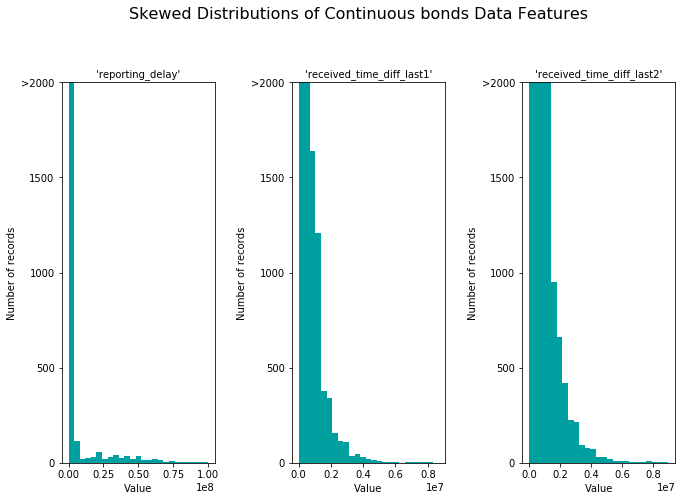

In [7]:
skewed_features_complete = ['reporting_delay', 'received_time_diff_last1', 'received_time_diff_last2']

dist_plot = vs.distribution(train_data, skewed_features_complete)

dist_plot.show()

### Preprocessing: Transforming highly-skewed features.

Log-transform will be applied to every highly skewed feature in order to mitigate the range effect caused by the outliers.

In [8]:
features_log_scaled = pd.DataFrame(data = train_data)
features_log_scaled[skewed_features_complete] = features_log_scaled[skewed_features_complete].apply(lambda x: np.log(x + 1))

features_log_scaled.skew()

/Users/juanjpolanco/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


weight                       4.168212
current_coupon               0.138092
time_to_maturity             2.207825
is_callable                  2.493553
reporting_delay              2.049124
trade_size                   4.725893
trade_type                  -0.423545
curve_based_price           -1.244529
received_time_diff_last1     0.160289
trade_price_last1           -1.363332
trade_size_last1             4.728423
trade_type_last1            -0.423976
curve_based_price_last1     -1.242974
received_time_diff_last2    -0.255990
trade_price_last2           -1.362492
trade_size_last2             4.728296
trade_type_last2            -0.424576
curve_based_price_last2     -1.241852
received_time_diff_last3     8.947340
trade_price_last3           -1.361715
trade_size_last3             4.728967
trade_type_last3            -0.424483
curve_based_price_last3     -1.240483
received_time_diff_last4     7.818396
trade_price_last4           -1.361161
trade_size_last4             4.727660
trade_type_l

### Preprocessing: Normalizing features

I'll proceed to use Z-score normalization scaling to the features so values fall into a common range and are treated equally by the supervised learning algorithms. With this we avoid the effect caused by the range of each feature and prediction/estimations have less biases. Also most ML algorithms require that data is correctly normalized. StandardScaler implement the Z-score normalization.

In [9]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

features_standarized = pd.DataFrame(data = features_log_scaled)
features_standarized = features_standarized.apply(lambda x: np.nan_to_num(x))
features_standarized[features_standarized.columns.values] = scaler.fit_transform(features_standarized[features_standarized.columns.values])

features_standarized

,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,3.351183,0.213277,3.110719,-0.351489,-0.054530,-0.148447,-0.307101,2.318094,1.951679,2.226017,0.177423,-0.307323,2.186363,1.626476,2.190966,0.959058,-0.30771,2.186976,2.244121,2.324862,-0.057134,-0.307605,2.335005,3.665979,2.615156,-0.306122,1.001784,2.381414,3.109589,2.208388,-0.330931,-1.616806,2.290432,4.648670,2.356807,6.168288,-1.616674,2.421460,4.097276,2.410331,5.126203,-0.307538,2.394961,4.128328,2.389512,-0.233495,1.001440,2.350899,4.508990,2.587014,-0.187998,-1.616491,2.476665,5.327763,2.638023,-0.084046,-1.615111,2.666961
1,2.758691,0.213277,3.109472,-0.351489,-0.805750,1.414198,-0.307101,2.545731,1.862380,2.345625,-0.148296,-0.307323,2.318140,1.795636,2.226220,0.177376,-0.30771,2.186536,1.891446,2.191233,0.959310,-0.307605,2.187167,2.530147,2.325159,-0.057244,-0.307514,2.335217,3.729815,2.615509,-0.306184,1.001614,2.381659,3.242733,2.208831,-0.331001,-1.616674,2.290730,4.601629,2.357246,6.168162,-1.616609,2.421756,4.118902,2.410727,5.125382,-0.307584,2.395291,4.146090,2.389920,-0.233585,1.001468,2.351191,4.507782,2.587490,-0.188188,-1.615111,2.476929
2,3.861788,0.213277,3.107226,-0.351489,0.190721,-0.330755,-0.307101,2.502267,2.018146,2.564037,1.415154,-0.307323,2.545748,1.844346,2.345818,-0.148325,-0.30771,2.318302,3.544295,2.226485,0.177430,-0.307605,2.186727,2.848447,2.191535,0.959119,-0.307514,2.187386,3.278005,2.325513,-0.057416,-0.307596,2.335463,4.249112,2.615970,-0.306254,1.001550,2.381959,3.758622,2.209262,-0.331048,-1.616609,2.291023,4.947646,2.357639,6.167206,-1.616607,2.422088,4.477554,2.411136,5.126219,-0.307512,2.395585,4.486717,2.390381,-0.233750,1.001785,2.351450
3,2.318664,0.213277,3.106296,-0.351489,0.554543,-0.337266,-0.307101,2.264661,1.784712,2.781361,-0.330698,-0.307323,2.502289,1.814254,2.564210,1.415039,-0.30771,2.545892,2.941049,2.346075,-0.148354,-0.307605,2.318485,3.412551,2.226785,0.177301,-0.307514,2.186945,2.860630,2.191890,0.958494,-0.307596,2.187635,3.244437,2.325962,-0.057484,-0.307562,2.335762,4.114545,2.616423,-0.306301,1.001532,2.382254,3.694253,2.209648,-0.331166,-1.616607,2.291347,4.786512,2.358044,6.168223,-1.616491,2.422383,4.379159,2.411598,5.123050,-0.306663,2.395846
4,3.758870,0.213277,3.104156,-0.351489,0.536594,-0.333360,-0.307101,2.482388,2.005403,2.878903,-0.337213,-0.307323,2.264714,1.803566,2.781514,-0.330718,-0.30771,2.502437,3.600416,2.564452,1.415407,-0.307605,2.546060,3.652685,2.346371,-0.148456,-0.307514,2.318697,3.981059,2.227140,0.177025,-0.307596,2.187195,3.436249,2.192333,0.958437,-0.307562,2.187931,3.716676,2.326399,-0.057534,-0.307538,2.336056,4.467511,2.616828,-0.306423,1.001440,2.382584,4.053752,2.210044,-0.331273,-1.616491,2.291636,5.044560,2.358503,6.164471,-1.615111,2.422645
5,4.199324,0.213277,3.101546,-0.351489,-0.569287,0.828206,-1.616735,2.480311,2.057907,2.845653,-0.333304,-0.307323,2.482412,1.941576,2.879047,-0.337232,-0.30771,2.264880,3.8690

### Splitting the training dataset into training and testing sets.

In [10]:
from sklearn import model_selection

features_train, features_test, prices_train, prices_test = model_selection.train_test_split(features_standarized, bond_prices, test_size=0.2, random_state=1)

print("Training set has {} samples.".format(features_train.shape[0]))
print("Testing set has {} samples.".format(features_test.shape[0]))

Training set has 596007 samples.
Testing set has 149002 samples.


### Training and testing pipeline.

With the pipeline we'll be able to train/test up to 3 candidate ML algorithms. I'm using the pipeline used on the Project Finding donors for CharityML, just that in this case will be changed for regression instead of classification.

In [11]:
# Import two metrics from sklearn - R^2 and MSE.
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from time import time
import matplotlib.patches as mpatches


def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    Title: Training/predicting pipeline for measuring scores and training time.
    Author: Udacity.
    Date: Jan 25, 2017.
    Code version: master (using branch since they don't have tag version in their github repo)
    Availability: https://github.com/udacity/machine-learning/blob/master/projects/finding_donors/finding_donors.ipynb
    
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute r2_score on the first 300 training samples
    results['r2_train'] = r2_score(y_train[:300], predictions_train)
        
    # Compute r2_score on test set
    results['r2_test'] = r2_score(y_test,predictions_test)
    
    # Compute MSE on the the first 300 training samples.
    results['mse_train'] = mean_squared_error(y_train[:300],predictions_train)
        
    # Compute MSE on the test set
    results['mse_test'] = mean_squared_error(y_test,predictions_test)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Helper functions for model plotting.

In [13]:
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, validation_curve


def ModelLearningBaggingReg(X,y):
    '''
    Title: Calculates the performance of several models with varying sizes of training data. Scores are then plotted.
    Author: Udacity.
    Date: Jan 25, 2017.
    Code version: master (using branch since they don't have tag version in their github repo)
    Availability: https://github.com/udacity/machine-learning/blob/master/projects/boston_housing/boston_housing.ipynb
    
    Notes: This a modified version of the ModelLearning function from the Boston Housing problem, adapted to the 
           BaggingRegressor model.
    '''
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.008 - 1, 9)).astype(int)

    # Create the figure window
    fig = plt.figure(figsize=(20,17))

    # Create three different models based on max_depth
    for k, estimators in enumerate([10,20,30,40]):
        
        # Create a Stochastic Gradient Descent regressor at learning_rate = rate
        regressor = BaggingRegressor(n_estimators = estimators)

        # Calculate the training and testing scores
        sizes, train_scores, test_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'neg_mean_squared_error', n_jobs = 4, verbose = 1)
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores*(-1), axis = 1)
        train_mean = np.mean(train_scores*(-1), axis = 1)
        test_std = np.std(test_scores*(-1), axis = 1)
        test_mean = np.mean(test_scores*(-1), axis = 1)

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.1, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.1, color = 'g')
        
        # Labels
        ax.set_title('n_estimators = %s'%(estimators))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        # ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_xlim([0, X.shape[0]*0.008 - 1], auto = True)
        # ax.set_ylim([-0.05, 1.05])
        ax.set_ylim([0, 5])
    
    # Visual aesthetics
    ax.legend(loc='upper right', borderaxespad = 0.)
    fig.suptitle('BaggingRegressor Learning Performances', fontsize = 20, y = 1.03)
    fig.tight_layout()
    fig.show()


def evaluate(results):
    """
    Title: Visualization code to display results of various learners.
    Author: Udacity.
    Date: Jan 25, 2017.
    Code version: master (using branch since they don't have tag version in their github repo)
    Availability: https://github.com/udacity/machine-learning/blob/master/projects/boston_housing/boston_housing.ipynb
    
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    # New colors: Orange (#F28D09), Yellow (#F9EA5E), Blue (#74A6ED)
    colors = ['#74A6ED','#F9EA5E','#F28D09']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'r2_train', 'mse_train', 'pred_time', 'r2_test', 'mse_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("R2 Score")
    ax[0, 2].set_ylabel("MSE-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("R2 Score")
    ax[1, 2].set_ylabel("MSE-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("R2 Score on Training Subset")
    ax[0, 2].set_title("MSE-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("R2 Score on Testing Set")
    ax[1, 2].set_title("MSE-score on Testing Set")
        
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 10))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 10))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-0.80, 1.53), \
              loc = 'upper left', borderaxespad = 0.)
    
    # Aesthetics
    plt.suptitle("Performance Metrics for three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

### Selecting algorithms to train/test.

I'm going to choose 3 candidate algorithms for this problem: Stochastic Gradient Descent (SGD), Decision Trees and BaggingRegressor

/Users/juanjpolanco/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDRegressor trained on 5960 samples.
SGDRegressor trained on 59601 samples.
SGDRegressor trained on 596007 samples.
DecisionTreeRegressor trained on 5960 samples.
DecisionTreeRegressor trained on 59601 samples.
DecisionTreeRegressor trained on 596007 samples.
BaggingRegressor trained on 5960 samples.
BaggingRegressor trained on 59601 samples.
BaggingRegressor trained on 596007 samples.


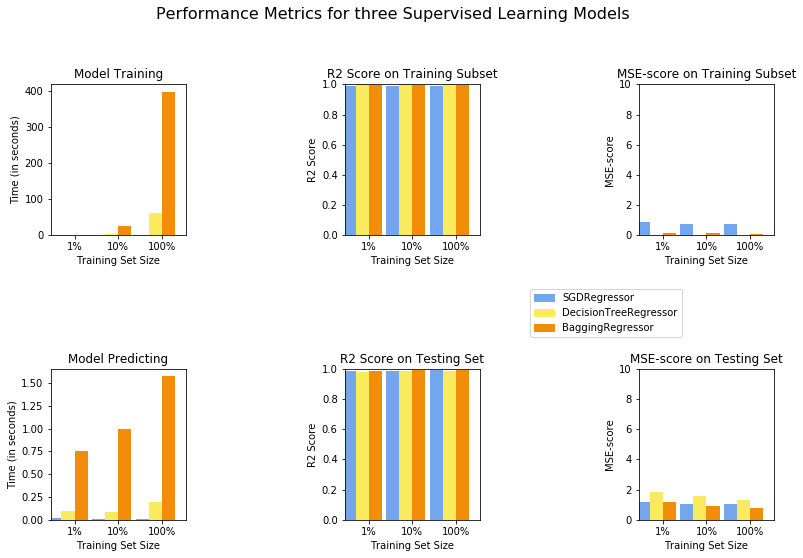

In [14]:
'''
Title: Pipeline execution code.
Author: Udacity.
Date: Jan 25, 2017.
Code version: master (using branch since they don't have tag version in their github repo)
Availability: https://github.com/udacity/machine-learning/blob/master/projects/boston_housing/boston_housing.ipynb
'''

# Initialize the three models
reg_A = SGDRegressor()
reg_B = DecisionTreeRegressor()
reg_C = BaggingRegressor()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(features_train.shape[0] * 0.01))
samples_10 = int(round(features_train.shape[0] * 0.1))
samples_100 = int(round(features_train.shape[0]))

# Collect results on the learners
results = {}
for reg in [reg_A, reg_B, reg_C]:
    reg_name = reg.__class__.__name__
    results[reg_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[reg_name][i] = \
        train_predict(reg, samples, features_train, prices_train, features_test, prices_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

### Benchmark model: Random Forest model.

Here I will re-write the Benchmark model that was written in R to solve this problem, in Python with the same parameter that was set on R. Then I'll measure the R2 score and MSE score and use it as the benchmark score to beat, with the SGD.

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=200, verbose=2, n_jobs=-1)
rf_regressor.fit(features_train, prices_train)

predictions_test = rf_regressor.predict(features_test)
#--predictions_train = rf_regressor.predict(features_train)

rf_r2score = r2_score(predictions_test, prices_test)
rf_mse_score = mean_squared_error(predictions_test, prices_test)

print("R2 score for Random Forest: ", rf_r2score)
print("MSE score for Random Forest: ", rf_mse_score)

building tree 1 of 200building tree 2 of 200
building tree 3 of 200building tree 4 of 200

building tree 5 of 200

building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200building tree 14 of 200

building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.1min


building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200building tree 53 of 200

building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 20.2min


building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 26.7min finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    6.5s


R2 score for Random Forest:  0.9928279655017713
MSE score for Random Forest:  0.6827740008417598


[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    8.9s finished


### Selecting the baseline model: tweaking best pipeline's model parameters.

Based on the results of the training/testing pipeline, the selected model will be the Stochastic Gradient Descent Regressor (SGDRegressor). Now I'll use GridSearchCV and Complexity diagrams to tune the parameters of the model and find the best parameter set that defines the best baseline model.

[learning_curve] Training set sizes: [   1  597 1193 1788 2384 2980 3576 4171 4767]


[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:   48.9s finished


[learning_curve] Training set sizes: [   1  597 1193 1788 2384 2980 3576 4171 4767]


[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  1.2min finished


[learning_curve] Training set sizes: [   1  597 1193 1788 2384 2980 3576 4171 4767]


[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  1.7min finished


[learning_curve] Training set sizes: [   1  597 1193 1788 2384 2980 3576 4171 4767]


[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  2.2min finished


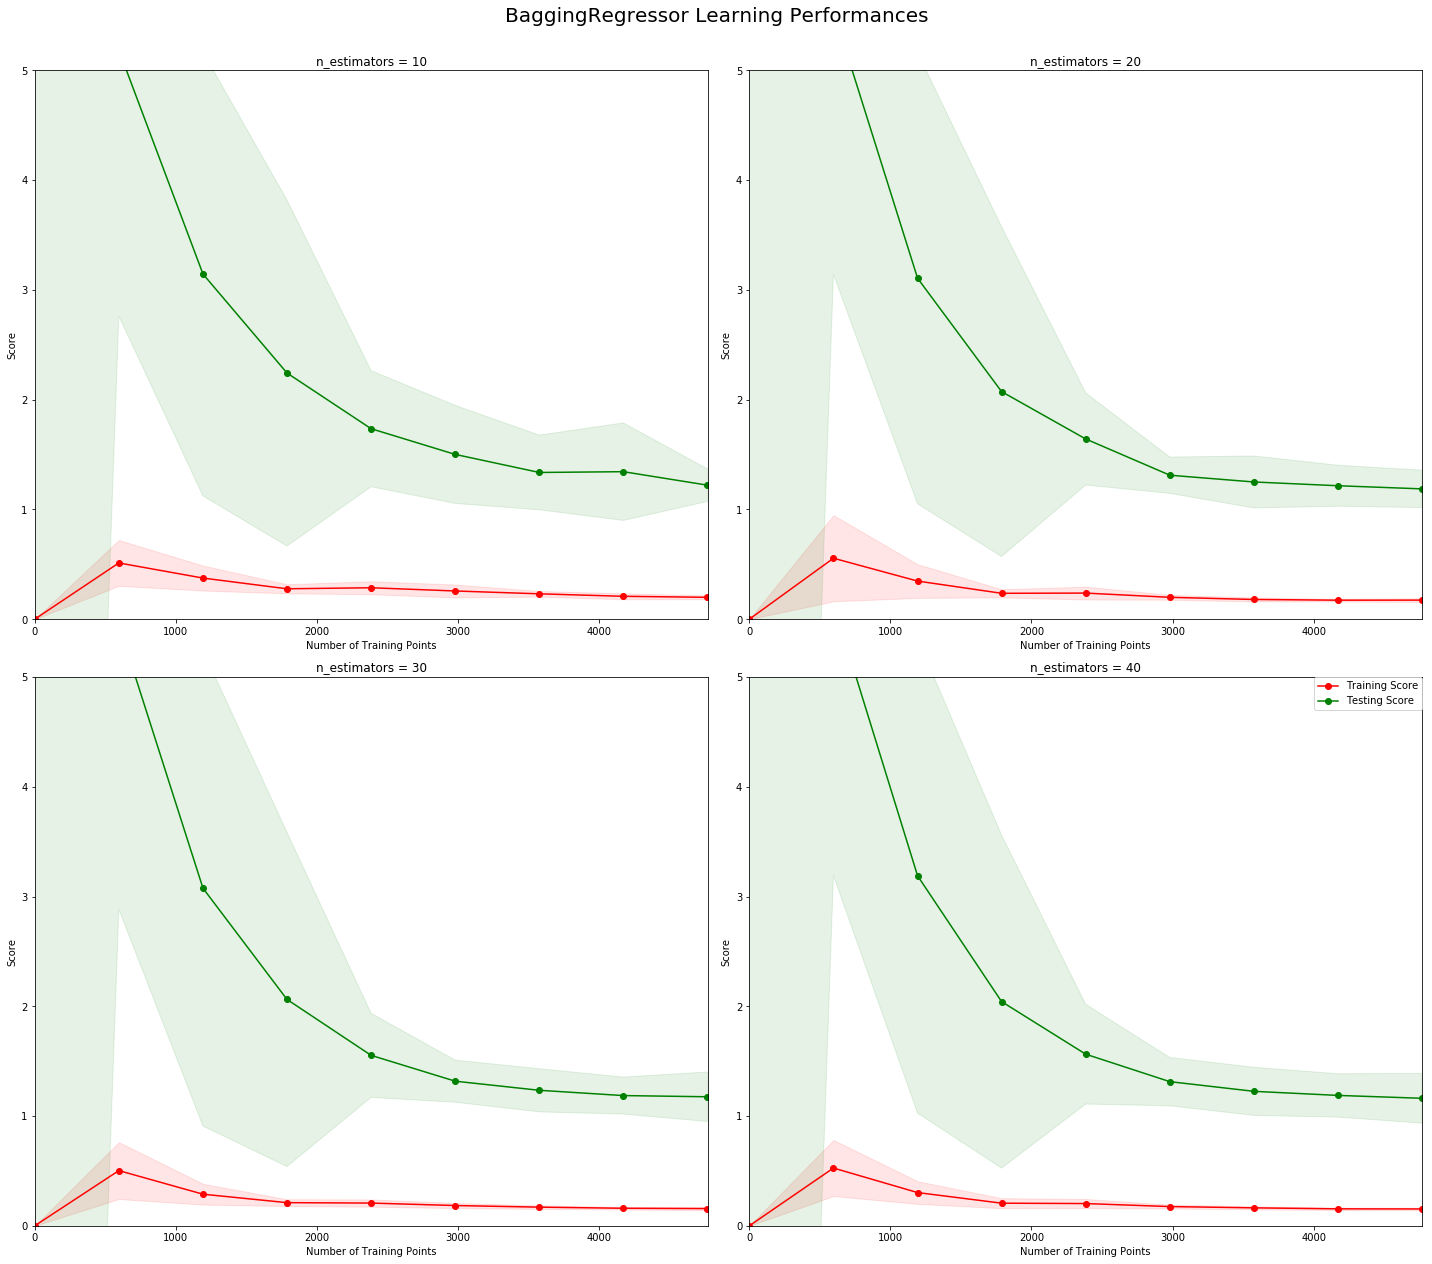

In [15]:
ModelLearningBaggingReg(features_train, prices_train)

After plotting the model's complexity we can confirm the choice made on the previous learning curves plot: The number of iterations of 10 is the best value, since the gap between training curve and validation curve is the same, which means that bias and variance are stable as the number of iterations increase. We can even choose a higher number of iterations (higher than 10) and still get the same gap, but the lower the number of iterations the lower training time.

In [18]:
# Using BaggingRegressor with the best parameters.
ens_reg = BaggingRegressor(verbose=2, n_estimators=40, n_jobs=-1)
ens_reg.fit(features_train, prices_train)

ens_predicted = ens_reg.predict(features_test)
print("MSE score for BaggingRegressor: ", mean_squared_error(prices_test,ens_predicted))

Building estimator 1 of 5 for this parallel run (total 40)...
Building estimator 1 of 5 for this parallel run (total 40)...
Building estimator 1 of 5 for this parallel run (total 40)...
Building estimator 1 of 5 for this parallel run (total 40)...
Building estimator 1 of 5 for this parallel run (total 40)...
Building estimator 1 of 5 for this parallel run (total 40)...
Building estimator 1 of 5 for this parallel run (total 40)...
Building estimator 1 of 5 for this parallel run (total 40)...
Building estimator 2 of 5 for this parallel run (total 40)...
Building estimator 2 of 5 for this parallel run (total 40)...
Building estimator 2 of 5 for this parallel run (total 40)...
Building estimator 2 of 5 for this parallel run (total 40)...
Building estimator 2 of 5 for this parallel run (total 40)...
Building estimator 2 of 5 for this parallel run (total 40)...
Building estimator 2 of 5 for this parallel run (total 40)...
Building estimator 2 of 5 for this parallel run (total 40)...
Building

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  5.7min remaining:  9.5min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  6.0min finished
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.8s remaining:    6.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.8s finished


MSE score for BaggingRegressor:  0.6982117046039297


### Predicting bond prices with unseen bond data. 


Here model robustness will be tested with unseen data. This unseen data is not the test set we've used to measure performance, this is a separate dataset part of the bond price prediction competition: test_clean.csv. This dataset is based on the test.csv one, but without the id column since the bond ID is not relevant to the problem. Also all NaN values were deleted

In [19]:
# Preparing a new dataset with sample bonds to predict prices.
bonds_new_data = pd.read_csv('test_clean.csv')
bonds_to_test = bonds_new_data.loc[:9]
bonds_to_test

,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,0.733639,1.30278,1.090694,0,68.135,2250000,2,98.521799,3188,98.200000,5000001,3,98.501951,98934.0,98.0244,145000.0,4.0,98.526323,98934.0,98.0244,145000.0,2.0,98.526323,174891.0,98.200,5000001.0,3.0,98.488617,698564.0,97.942,5000001.0,2.0,98.293641,864615.0,98.850,300000.0,3.0,98.346771,865338.0,98.740,300000.0,4.0,98.353190,869248.0,98.000,100000.0,3.0,98.358220,869248.0,98.000,100000.0,4.0,98.358220,883612.0,97.050,100000.0,2.0,98.315355
1,0.403570,8.50000,7.472191,0,2.421,3000,2,119.292424,964,116.417666,3000,3,119.380981,964.0,116.1510,3000.0,4.0,119.380981,974.0,116.1510,3000.0,4.0,119.380981,65470.0,115.592,900000.0,3.0,118.288286,69638.0,115.268,10000.0,4.0,118.356743,69638.0,116.768,10000.0,3.0,118.356743,69873.0,115.500,195000.0,2.0,118.356743,69874.0,115.500,195000.0,3.0,118.356743,150886.0,115.166,1200000.0,2.0,117.986068,152610.0,115.342,2200000.0,2.0,117.950083
2,0.416940,8.62500,8.378550,1,25.469,1000000,4,103.973124,1029,104.750000,1000000,4,103.420577,8634.0,104.5000,1000001.0,2.0,103.528594,9664.0,104.5000,1000001.0,3.0,103.478882,16827.0,105.100,11000.0,3.0,102.802233,16827.0,105.000,11000.0,4.0,102.802233,16841.0,105.000,11000.0,4.0,102.802233,16842.0,105.000,11000.0,4.0,102.802233,82527.0,103.000,1000001.0,3.0,102.794562,82532.0,104.000,5000.0,4.0,102.794562,82534.0,104.000,5000.0,4.0,102.794562
3,0.012991,7.00000,1.715990,0,12.188,25000,4,106.680891,0,106.693000,15000,3,106.680891,0.0,106.6930,10000.0,3.0,106.680891,7.0,106.6930,25000.0,4.0,106.680891,510.0,107.875,70000.0,3.0,106.677745,695.0,106.693,70000.0,4.0,106.677745,2026.0,107.250,3000.0,3.0,106.683246,2151.0,106.693,9000.0,4.0,106.694550,2151.0,107.813,9000.0,3.0,106.694550,2209.0,106.754,10000.0,3.0,106.694550,2959.0,107.193,15000.0,3.0,106.711338
4,0.755066,8.00000,6.129066,1,437.017,1000001,2,102.530173,3377,102.410000,135000,4,102.559205,3941.0,102.4100,135000.0,3.0,102.558020,4688.0,102.2500,1000001.0,2.0,102.609730,5666.0,104.030,20000.0,3.0,102.569944,6009.0,102.285,15000.0,4.0,102.569944,6010.0,102.165,15000.0,2.0,102.569944,8389.0,102.375,680000.0,2.0,102.602887,10077.0,102.250,46000.0,2.0,102.599465,14662.0,103.900,1000000.0,3.0,102.638859,14883.0,102.750,1000001.0,4.0,102.638859
5,0.022502,6.00000,6.326842,0,3.347,10000,3,99.651523,2,99.618000,10000,4,99.651523,4.0,100.6360,12000.0,3.0,99.651523,31.0,99.8460,100000.0,4.0,99.651523,61.0,99.786,100000.0,4.0,99.651523,78.0,100.636,100000.0,3.0,99.651523,78.0,100.636,10000.0,3.0,99.651523,79.0,100.636,10000.0,3.0,99.651523,154.0,100.636,10000.0,3.0,99.702242,162.0,100.636,10000.0,3.0,99.702242,179.0,100.636,10000.0,3.0,99.702242
6,0.012991,6.37500,2.600702,0,114.000,15000,4,105.463058,0,105.481000,15000,4,105.463058,0.0,105.4810,18000.0,4.0,105.463058,0.0,105.4810,20000.0,4.0,105.463058,7.0,105.481,15000.0,3.0,105.463058,14.0,105.491,500000.0,4.0,105.463058,29.0,105.481,15000.0,3.0,105.46

### Predicting bond prices with new model.

Here we'll use the new BaggingRegressor model to predict some bond prices.

In [20]:
# TODO: To test robustness of the model, import the test set test.csv to predict 10 bond prices and see how the changes of
# input parameters affect output.

# Preprocessing new bonds data.

bonds_to_test[skewed_features_complete] = bonds_to_test[skewed_features_complete].apply(lambda x: np.log(x + 1))
bonds_to_test_std = bonds_to_test.apply(lambda x: np.nan_to_num(x))
bonds_to_test_std[bonds_to_test_std.columns.values] = scaler.fit_transform(bonds_to_test_std[bonds_to_test_std.columns.values])

new_bond_prices = ens_reg.predict(bonds_to_test_std)

# Table A. Standarized new bonds features
bonds_to_test_std

/Users/juanjpolanco/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.4s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.0s finished


,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,0.403367,-2.124631,-1.497954,-0.654654,0.298239,2.521520,-1.324244,-0.980104,0.889010,-1.187056,2.938203,-1.0,-0.968628,1.306695,-1.262584,-0.264589,1.290994,-0.972115,2.145770,-1.181608,-0.307242,-1.376494,-0.971752,0.756955,-1.254394,2.949683,-0.654654,-0.994398,2.510285,-1.286684,2.986341,-2.412091,-1.023387,2.664071,-1.158790,1.605907,0.000000,-1.015838,2.664025,-1.182991,0.614408,1.083473,-1.015426,2.640432,-1.204000,-0.161602,0.185695,-1.014943,2.623788,-1.306009,-0.331984,1.333333,-1.027759,2.627442,-1.411919,-0.477922,-1.603567,-1.035250
1,-0.117031,0.901879,1.014654,-0.654654,-1.495935,-0.680433,-1.324244,2.616097,0.547897,2.464607,-0.446352,-1.0,2.626956,0.170724,2.490915,-0.637322,1.290994,2.623537,-0.529257,2.441074,-0.687279,0.917663,2.624082,-0.100838,2.287347,0.155648,-0.654654,2.585143,-0.273438,2.346301,-0.389699,0.603023,2.580053,-0.291999,2.496445,-0.509048,0.000000,2.581388,-0.294371,2.429260,0.133686,-1.324244,2.581056,-0.351969,2.400791,0.166436,0.185695,2.583852,-0.085283,2.375686,2.216395,-2.000000,2.567302,-0.085977,2.332129,0.882388,-1.603567,2.563711
2,-0.095951,0.954443,1.371518,1.527525,-0.274778,0.740282,1.083473,-0.036268,0.566499,0.125867,0.228933,1.0,-0.121590,0.708386,0.078327,1.979687,-1.290994,-0.109649,-0.291956,0.112570,1.981012,-0.229416,-0.117814,-0.482169,0.150736,-0.450180,-0.654654,-0.214549,-0.507188,0.193266,-0.389023,0.603023,-0.213620,-0.488322,0.095797,-0.501755,2.236068,-0.214872,-0.491597,0.166215,-0.708721,1.083473,-0.215523,-0.304603,-0.174060,2.946129,0.185695,-0.216610,-0.343058,-0.019153,-0.552072,1.333333,-0.215193,-0.346093,0.010623,-0.539460,1.069045,-0.214230
3,-0.732830,0.271113,-1.251754,-0.654654,-0.690576,-0.649083,1.083473,0.432551,-1.413206,0.515334,-0.438224,-1.0,0.439870,-1.515320,0.532434,-0.618947,0.000000,0.433854,-0.555663,0.550851,-0.628400,0.917663,0.434287,-0.610084,0.715842,-0.409973,-0.654654,0.486097,-0.578590,0.548261,-0.349106,0.603023,0.482442,-0.543410,0.554793,-0.560098,0.000000,0.482824,-0.546234,0.531104,-0.717878,1.083473,0.484285,-0.605485,0.817361,-0.475828,0.185695,0.485205,-0.645970,0.571514,-0.540488,-0.333333,0.499134,-0.641469,0.664173,-0.532982,-0.267261,0.503698
4,0.437150,0.691624,0.485821,1.527525,1.400121,0.740284,-1.324244,-0.286099,0.905441,-0.343177,-0.356946,1.0,-0.269927,0.516002,-0.354452,-0.290837,0.000000,-0.276990,-0.427838,-0.337103,1.981012,-1.376494,-0.267677,-0.569665,-0.067161,-0.444047,-0.654654,-0.256543,-0.555070,-0.376026,-0.386316,0.603023,-0.255340,-0.528596,-0.482537,-0.472583,-2.236068,-0.256631,-0.523035,-0.399546,2.354164,-1.324244,-0.251364,-0.575815,-0.328551,-0.348066,-1.671258,-0.251718,-0.599008,-0.040600,1.753053,-0.333333,-0.243711,-0.597208,-0.245230,0.105068,1.069045,-0.242770
5,-0.717836,-0.149398,0.563692,-0.654654,-1.352960,-0.670458,-0.120386,-0.784505,-1.099694,-0.902823,-0.441611,1.0,-0.770

In [21]:
# Showing prices predictions for each of the previous bonds.
new_price_data = {'trade_price':new_bond_prices}
new_price_df = pd.DataFrame(data=new_price_data)

# Table B. New bonds price predictions.
new_price_df

,trade_price
0,92.018495
1,126.820112
2,103.842628
3,108.323595
4,99.945961
5,95.389042
6,105.841954
7,101.585200
8,107.575082
9,92.860617


### Comparing with previous test set

In [22]:
# Table C. Previous test set (used to calculate performance metrics).
features_test_sample = features_test[:10]
features_test_sample

,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
390692,-0.460270,0.242377,-0.036474,-0.351489,-0.952285,-0.330755,1.002533,0.027083,-1.423477,0.212448,-0.330698,-0.307323,0.027420,-0.031043,0.069565,-0.311176,1.00183,0.024375,-0.316759,0.069971,-0.311245,1.001847,0.024703,-0.351211,0.198444,-0.311334,-0.307514,0.025022,-0.374335,0.068672,-0.304882,1.001614,0.035512,-0.395854,0.069023,-0.304952,1.001550,0.035772,-0.412903,0.197437,-0.304999,-0.307538,0.036006,-0.427024,-0.087902,1.609229,1.001440,0.036210,-0.439351,-0.087646,1.609458,-1.616491,0.036393,-0.442872,0.067911,-0.311857,1.001785,0.029983
272104,-0.293632,0.125978,2.923637,-0.351489,-0.927030,-0.321640,1.002533,1.374500,0.313665,1.095421,-0.321578,-1.616854,1.372457,-0.329070,1.236643,-0.321598,1.00183,1.372693,-0.309687,1.115845,-0.295608,-1.617056,1.355211,-0.126345,1.386408,-0.324365,-1.616813,1.271058,-0.184675,1.384411,-0.324419,1.001614,1.271326,-0.203601,1.415373,-0.303649,1.001550,1.406519,-0.241347,1.346568,-0.295882,1.001532,1.406789,-0.272266,1.343867,-0.296004,-1.616607,1.407067,-0.297763,1.375033,-0.296105,1.001468,1.407314,-0.317635,1.314341,-0.318366,-1.615111,1.389167
53907,-0.341522,-1.067108,-0.589460,-0.351489,-0.144565,-0.303409,-0.307101,0.246120,0.142221,0.260312,-0.337213,-1.616854,0.246429,-0.135522,0.220523,0.698497,-1.61725,0.247951,-0.310651,0.238340,-0.304730,-0.307605,0.248177,-0.346106,0.218221,-0.304819,-1.616813,0.248486,-0.371778,0.236316,6.168294,-0.307596,0.250295,-0.383333,0.227144,-0.213779,-1.616674,0.254142,-0.401700,0.227464,-0.213828,1.001532,0.254382,-0.408323,0.263525,-0.213961,-0.307584,0.249628,-0.401139,0.212761,3.042212,-1.616491,0.251443,-0.313732,0.270761,-0.341798,-0.306663,0.252138
578112,-0.124548,-2.158345,-0.741810,-0.351489,-0.492587,2.911732,-0.307101,-0.248870,0.674457,-0.275622,-0.311155,-1.616854,-0.251407,0.298479,-0.281747,-0.259064,-1.61725,-0.253803,-0.302063,-0.269841,-0.259120,1.001847,-0.253476,-0.337724,-0.257968,4.698811,-0.307514,-0.252407,-0.366373,-0.257599,4.696524,-1.616806,-0.252107,-0.386203,-0.256544,-0.317976,-0.307562,-0.250660,-0.404260,-0.256251,-0.318023,1.001532,-0.250433,-0.415252,-0.257825,0.111609,1.001440,-0.253358,-0.420875,-0.276746,-0.159342,-1.616491,-0.253673,-0.424446,-0.257325,0.931338,-0.306663,-0.247796
425981,-0.452221,0.038679,-0.029856,-0.351489,-1.040783,-0.338568,1.002533,1.828721,-0.997352,1.816354,-0.338516,-1.616854,1.828829,1.516467,1.899197,-0.213465,-0.30771,1.802342,0.596522,1.780097,-0.338611,-1.617056,1.805244,0.404669,1.780415,-0.338698,1.001784,1.805480,0.272998,1.891954,2.260944,-0.307596,1.805975,0.174095,1.936654,-0.342723,-0.307562,1.806363,0.095703,1.937069,-0.342770,1.001532,1.806643,0.033289,1.848894,-0.324655,-1.616607,1.806942,0.009266,1.785825,-0.341693,1.001468,1.804115,-0.036507,1.734989,-0.341798,-1.615111,1.804350
704810,-0.445184,-1.067108,-0.326342,-0.351489,0.053124,-0.337266,1.002533,-0.

In [23]:
# Table D. Showing prices for initial test sets ( split from train_clean.csv )
prices_test_sample = prices_test[:10]
prices_test_sample = prices_test_sample.to_frame()
prices_test_sample

,trade_price
390692,103.948
272104,116.379
53907,105.925
578112,100.802
425981,121.354
704810,94.474
732115,100.755
497210,102.180
11397,111.745
267395,105.507


In [24]:
# Table E. Showing feature percentage variation (%).
features_diff = pd.DataFrame(((bonds_to_test_std.values - features_test_sample.values)/features_test_sample.values*100), columns=features_test_sample.columns)
features_diff

,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,-187.637094,-976.581721,4006.874349,86.251410,-131.318312,-862.352427,-232.089882,-3718.918106,-162.453403,-658.751918,-988.484207,225.390589,-3632.540934,-4309.324122,-1914.964739,-14.971327,28.863664,-4088.212387,-777.413412,-1788.707051,-1.286340,-237.395732,-4033.761104,-315.527470,-732.114074,-1047.432726,112.885495,-4074.045917,-770.598761,-1973.669149,-1079.507848,-340.820312,-2981.838656,-772.992882,-1778.844517,-626.610407,-100.000000,-2939.787377,-745.194103,-699.174188,-301.446018,-452.305023,-2920.160662,-718.333061,1269.703299,-110.042210,-81.457175,-2902.900744,-697.196225,1390.095880,-120.627090,-182.483180,-2924.044400,-693.273793,-2179.074149,53.250575,-260.071037,-3552.795902
1,-60.143788,615.900959,-65.294808,86.251410,61.368601,111.551275,-232.089882,90.330778,74.675805,124.991729,38.800474,-38.151490,91.405423,-151.880643,101.425519,98.173330,28.863664,91.123443,70.900722,118.764575,132.496825,-156.748978,93.629138,-20.188596,64.983656,-147.985536,-59.509620,103.385139,48.064106,69.480109,20.122369,-39.794922,102.941806,43.417734,76.380663,67.643381,-100.000000,83.530237,21.969850,80.403852,-145.182377,-232.221838,83.471393,29.273934,78.648019,-156.227451,-111.486731,83.633934,-71.358787,72.773047,-848.515607,-299.706836,82.425696,-72.932321,77.437195,-377.161710,-0.714732,84.550266
2,-71.904953,-189.442058,-332.673625,-534.586623,90.071551,-343.988332,-452.806596,-114.736072,298.322400,-51.647641,-167.889830,-161.848510,-149.340855,-622.707634,-64.481327,183.420999,-20.173460,-144.222041,-6.017923,-52.769119,-750.088186,-25.418695,-147.471916,39.312770,-30.925301,47.687674,-59.509620,-186.342360,36.422224,-18.217203,-106.306811,-296.043994,-185.347210,27.388357,-57.825250,134.706960,-238.312819,-184.547911,22.379332,-26.926806,231.445028,8.181504,-184.724055,-25.401460,-166.050609,-1476.947615,-160.372331,-186.772924,-14.478960,-109.001969,-118.147045,-182.483180,-185.583160,10.314742,-96.076605,57.830296,-448.605626,-184.965636
3,488.393884,-112.561139,68.743367,86.251410,40.193742,-122.291991,-452.806596,-273.805680,-309.532355,-286.971459,40.837839,-38.151490,-274.962906,-607.680691,-288.976037,138.917265,-100.000000,-270.940867,83.956091,-304.139330,142.512979,-8.402845,-271.332994,80.645653,-377.492110,-108.725047,112.885495,-292.584420,57.923890,-312.835307,-107.433275,-137.297169,-291.364078,40.705910,-316.256184,76.144713,-100.000000,-292.621278,35.119485,-307.259335,125.731142,8.181504,-293.379177,45.811390,-417.020957,-526.335533,-81.457175,-291.509507,53.482761,-306.512401,239.199021,-79.379205,-296.762848,51.130688,-358.106814,-157.227639,-12.848594,-303.271113
4,-196.667373,1688.100512,-1727.236740,-534.586623,-234.525831,-318.651156,-232.089882,-115.644766,-190.784480,-118.893751,5.444544,-161.848510,-114.759565,-65.973410,-118.663275,36.245663,-100.000000,-115.368359,-171.722067,-118.937

In [25]:
# Table F. Showing prices percentage variation.
prices_diff = pd.DataFrame((new_price_df.values - prices_test_sample.values)/prices_test_sample.values*100, columns=new_price_df.columns)
prices_diff

,trade_price
0,-11.476416
1,8.971647
2,-1.965893
3,7.461752
4,-17.640983
5,0.968565
6,5.048835
7,-0.582110
8,-3.731638
9,-11.986297


After getting the percentage variation of the features from the 2 datasets (the original test set used to measure the model metrics) and the new one to make predictions, as well as their prices percentage variation, it can be said that the model is a robust model. To confirm that I took the first datapoints differences from Table E and saw that most of the features have a percentage variation below -100% (some of them even below -1000%) which means there is a huge variation on those features, however, the price variation is minimal (-11%). Also another example is the datapoint 7 from Table E which has feature variations above 100% (and even above 1000%) and the price variation is minimal (-0.84%), which means in general that big perturbations to the input data don't cause big changes on the prediction of the target variable. Therefore, the predictions from this model can be trusted.